# Building a Custom Visualization

### Problem Statement:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))

In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data. Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean.

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


In [6]:
# Following data are used:

import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])
df

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
1992,-8941.531897,127788.667612,-71887.743011,-79146.060869,425156.114501,310681.166595,50581.575349,88349.230566,185804.513522,281286.947277,...,171938.760289,150650.759924,203663.976475,-377877.158072,-197214.093861,24185.008589,-56826.729535,-67319.766489,113377.299342,-4494.878538
1993,-51896.094813,198350.518755,-123518.252821,-129916.759685,216119.147314,49845.883728,149135.648505,62807.672113,23365.577348,-109686.264981,...,-44566.520071,101032.122475,117648.199945,160475.622607,-13759.888342,-37333.493572,103019.841174,179746.127403,13455.493990,34442.898855
1994,152336.932066,192947.128056,389950.263156,-93006.152024,100818.575896,5529.230706,-32989.370488,223942.967178,-66721.580898,47826.269111,...,165085.806360,74735.174090,107329.726875,199250.734156,-36792.202754,-71861.846997,26375.113219,-29328.078384,65858.761714,-91542.001049
1995,-69708.439062,-13289.977022,-30178.390991,55052.181256,152883.621657,12930.835194,63700.461932,64148.489835,-29316.268556,59645.677367,...,-13901.388118,50173.686673,53965.990717,4128.990173,72202.595138,39937.199964,139472.114293,59386.186379,73362.229590,28705.082908


              mean         i_min         i_max          yerr            std  \
1992  33312.107476  20034.653462  46589.561489  13277.454014  200603.415985   
1993  41861.859541  35350.328798  48373.390284   6511.530743   98384.876053   
1994  39493.304941  30204.060270  48782.549613   9289.244671  140350.695166   
1995  47743.550969  43125.912861  52361.189078   4617.638108   69771.625748   

              sem  
1992  3319.363503  
1993  1627.882686  
1994  2322.311168  
1995  1154.409527  


<IPython.core.display.Javascript object>


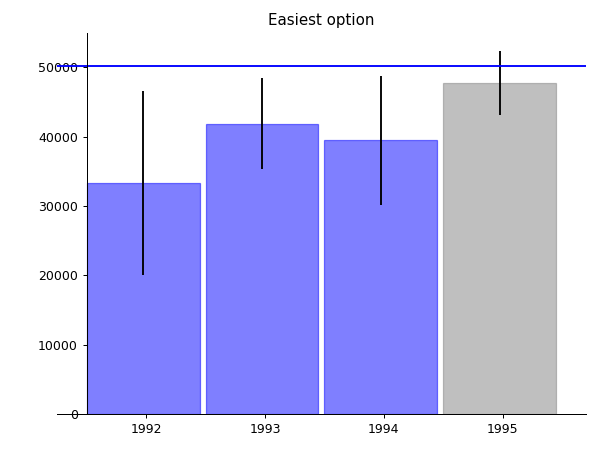

7

In [7]:
df['mean']=df.mean(axis=1)
df['std']=df.std(axis=1)

#this is approximate method for interval
df['sem']=df.sem(axis=1)
df['i_min']=df['mean']-df['sem']*4
df['i_max']=df['mean']+df['sem']*4

df['yerr']=df['sem']*4 
print(df[['mean', 'i_min', 'i_max', 'yerr', 'std', 'sem']])



%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

cl_max_color='red'
cl_min_color='blue'
cl_neitral_color='grey'

class Cursor(object):
    _df=None
    _bl=None
    def __init__(self, ax, data_F, bars):
        self._df=data_F
        self._bl=bars
        self.ax = ax
        self.lx = ax.axhline(color='b')

    def mouse_move(self, event):
        if not event.inaxes:
            return
        x, y = event.xdata, event.ydata
        self.lx.set_ydata(y)
        for index, row in self._df.iterrows():
            if row['i_max']<y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_min_color)
                continue
            if row['i_min']>y:
                self._bl[self._df.index.get_loc(index)].set_color(cl_max_color)
                continue
            
            self._bl[self._df.index.get_loc(index)].set_color(cl_neitral_color)
        plt.draw()

        
def plot_base(fix_x, fig_y, fig_title, c_alpha=0.5):
    ax=df['mean'].plot.bar(yerr=df['yerr'], 
        title =fig_title, figsize=(fix_x, fig_y), 
        legend=False, fontsize=10, alpha=c_alpha, width=0.95, 
        rot=0, position=0, style='-', color=cl_neitral_color)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    majors = [0.5,1.5,2.5, 3.5]
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))

    plt.tight_layout()
    
    return (ax, ax.get_children()[1:5])

ax, barlist=plot_base(5, 5, "Easiest option")

cursor = Cursor(ax, df, barlist)
plt.connect('motion_notify_event', cursor.mouse_move)